In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_graphics as tfg

import dataset

In [2]:
def get_features_model(trainable=False, hidden_size=1024):
    pretrained = keras.applications.Xception(include_top=False)
    pretrained.trainable=trainable
    return keras.models.Sequential([
        pretrained,
        keras.layers.Dense(hidden_size),
        keras.layers.Flatten()
    ])

def get_mlp_model(hidden_size=512, nb_layer=6, activation=None):
    if activation is None:
        activation = keras.layers.LeakyReLU(0.2)
    layers = []
    for _ in range(nb_layer):
        layers.append(keras.layers.Dense(hidden_size))
        layers.append(activation)
    layers.append(keras.layers.Dense(3))
    
    return keras.models.Sequential(layers)

def get_full_model(features_model, mlp_models, hidden=512, activation=None, im_size=128):
    """
    Assamble the atlas net model
    each input_coord is expected of shape [batch, n_points, 3]
    """
    if activation is None:
        activation = keras.layers.LeakyReLU(0.2)
        
    input_image = keras.layers.Input((im_size,im_size,3))
    inputs_coord = [keras.layers.Input((None,2)) for _ in mlp_models]
    features = features_model(input_image)
    outputs = []
    for mlp_model, coord in zip(mlp_models, inputs_coord):
        x = keras.layers.Dense(hidden)(features)
        coord = keras.layers.Dense(hidden)(coord)
        x = activation(x[:,tf.newaxis,:]+coord)
        output = mlp_model(x)
        outputs.append(output)
    output = tf.concat(outputs, axis=1)
    return keras.models.Model((input_image, *inputs_coord), output)

In [3]:
nb_mlps = 2
features_model = get_features_model()
mlp_models = [get_mlp_model() for i in range(nb_mlps)]

In [4]:
full_model = get_full_model(features_model, mlp_models)

In [5]:
nb_points_sqrt = 30
X = np.linspace(0,1,nb_points_sqrt)
X = np.stack([X, np.zeros_like(X)], axis=-1)[:, np.newaxis, :]
Y = np.linspace(0,1,nb_points_sqrt)
Y = np.stack([np.zeros_like(Y), Y], axis=-1)[np.newaxis, :, :]
grid = X+Y
grid = np.reshape(grid, (nb_points_sqrt*nb_points_sqrt, 2))
grid = tf.constant(grid, dtype=tf.float32)

grids = [grid[np.newaxis, :, :] for i in range(nb_mlps)]

def make_train_dataset(x,y):
    batch_size = tf.shape(x)[0]
    grids = [tf.repeat(grid[np.newaxis, :, :], batch_size, axis=0) for i in range(nb_mlps)]
    return (x,*grids), y[:,:2000]
    

In [6]:
def chamfer_loss(y_true, y_pred):
    difference = (
        tf.expand_dims(y_true, axis=-2) -
        tf.expand_dims(y_pred, axis=-3))
    # Calculate the square distances between each two points: |ai - bj|^2.
    square_distances = tf.einsum("...i,...i->...", difference, difference)

    minimum_square_distance_a_to_b = tf.reduce_min(
        input_tensor=square_distances, axis=-1)
    minimum_square_distance_b_to_a = tf.reduce_min(
        input_tensor=square_distances, axis=-2)

    return (
        tf.reduce_mean(input_tensor=minimum_square_distance_a_to_b, axis=-1) +
        tf.reduce_mean(input_tensor=minimum_square_distance_b_to_a, axis=-1))


In [7]:
full_model.compile("adam", loss=chamfer_loss)

In [8]:
planes_path = "data/planes"
tf_dataset = dataset.dataset.read_dataset(planes_path, batch_size=8)
train_dataset = tf_dataset.map(make_train_dataset)

In [31]:
full_model.fit(train_dataset, epochs=100)

Epoch 1/100
      6/Unknown - 14s 2s/step - loss: 0.0383

KeyboardInterrupt: 

In [24]:
for x,y in train_dataset.take(1):
    pass

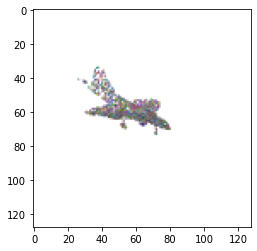

In [28]:
import os
os.environ["PYOPENGL_PLATFORM"] = "egl"
import numpy as np
import trimesh
import pyrender

pts = y[0].numpy()
colors = np.random.uniform(size=pts.shape)
m = pyrender.Mesh.from_points(pts, colors=colors)
scene = pyrender.Scene()
scene.add_node(pyrender.Node(mesh=m))
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
s = np.sqrt(2)/2
mat_default = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,1],
    [0,0,0,1],
])
scene.add(camera, pose=mat_default)

light = pyrender.SpotLight(color=np.ones(3), intensity=4.0,
                           innerConeAngle=np.pi/16.0)
scene.add(light, pose=mat_default)
light = pyrender.SpotLight(color=np.ones(3), intensity=6.0,
                           innerConeAngle=0.2*np.pi)
light_pose = np.array([
    [0,1,0,0],
    [0,0,1,1],
    [1,0,0,0],
    [0,0,0,1]
], dtype=np.float32)
scene.add(light, pose=light_pose)
r = pyrender.OffscreenRenderer(128, 128)
try :
    color2, depth = r.render(scene)
    plt.imshow(color2)
except Exception as e:
    print(type(e))

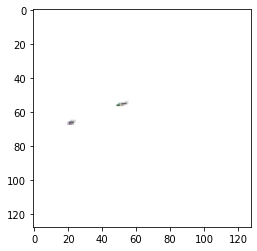

In [30]:
import os
os.environ["PYOPENGL_PLATFORM"] = "egl"
import numpy as np
import trimesh
import pyrender

pts = full_model(x)[0].numpy()
colors = np.random.uniform(size=pts.shape)
m = pyrender.Mesh.from_points(pts, colors=colors)
scene = pyrender.Scene()
scene.add_node(pyrender.Node(mesh=m))
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
s = np.sqrt(2)/2
mat_default = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,1],
    [0,0,0,1],
])
scene.add(camera, pose=mat_default)

light = pyrender.SpotLight(color=np.ones(3), intensity=4.0,
                           innerConeAngle=np.pi/16.0)
scene.add(light, pose=mat_default)
light = pyrender.SpotLight(color=np.ones(3), intensity=6.0,
                           innerConeAngle=0.2*np.pi)
light_pose = np.array([
    [0,1,0,0],
    [0,0,1,1],
    [1,0,0,0],
    [0,0,0,1]
], dtype=np.float32)
scene.add(light, pose=light_pose)
r = pyrender.OffscreenRenderer(128, 128)
try :
    color2, depth = r.render(scene)
    plt.imshow(color2)
except Exception as e:
    print(type(e))